In [6]:
import pandas as pd
import numpy as np
import glob

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import LatentDirichletAllocation

import scipy.sparse
from scipy.sparse import csr_matrix, hstack

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages')
from xgboost.sklearn import XGBClassifier

### Reading relevant files

In [7]:
ipb = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/ipblocks_fulldump_20190223.txt", sep ='\t')
#ipb = pd.read_csv("ipblocks_fulldump.csv")
ipb = ipb[['ipb_address','date']]
ipb.rename(columns = {'ipb_address':"username",'date':'bl_date'}, inplace=True)
ipb.bl_date = ipb.bl_date.astype('str')
ipb.bl_date = pd.to_datetime(ipb.bl_date)
ipb['ipb_bl'] = 1
print(len(ipb))
ipb.head()

1166572


,username,bl_date,ipb_bl
0,Wanli2,2004-02-08,1
1,Xuepiao,2004-02-08,1
2,GrandVoivodOfErdely,2004-02-08,1
3,#1703,2004-02-13,1
4,Wanli3,2004-03-14,1


In [8]:
files = glob.glob('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/csvs_stored/Blocked/*.csv')
d2=pd.DataFrame()
for file in files:
    d2s = pd.read_csv(file)
    d2 = pd.concat([d2,d2s])
print(d2.shape)
d2.dates = d2.dates.astype('str')
d2.dates = pd.to_datetime(d2.dates).dt.date
d2.dates = pd.to_datetime(d2.dates)
d2.drop(columns=['Unnamed: 0'], inplace=True)
d2.rename(columns={"user":"username","dates":"revision_date"},inplace=True)
d2['bl'] = 1
d2 = d2[~d2.char_changes.str.contains('-')]
print(d2.shape)
d2.tail()

(124102, 6)
(99761, 6)


,char_changes,revision_date,links,username,text,bl
32362,+420,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,:PROD = proposed deletion (anyone can challeng...,1
32363,+171,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::::::thanks, I think you will know who I am ...",1
32364,+924,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,"::::::{{reply to|Alexanderlee}}, no problems, ...",1
32365,+46,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::{{reply to|Snowflake91|Chrissymad}}Good, ac...",1
32366,+571,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::: I know, I am now exactly talking about so...",1


In [9]:
files = glob.glob('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/csvs_stored/Non_Blocked/*.csv')
d3=pd.DataFrame()
for file in files:
    d3s = pd.read_csv(file)
    d3 = pd.concat([d3,d3s])
print(d3.shape)
d3.dates = d3.dates.astype('str')
d3.dates = pd.to_datetime(d3.dates).dt.date
d3.dates = pd.to_datetime(d3.dates)
d3.drop(columns=['Unnamed: 0'], inplace=True)
d3.rename(columns={"user":"username","dates":"revision_date"},inplace=True)
d3['bl'] = 0
d3 = d3[~d3.char_changes.str.contains('-')]
print(d3.shape)
d3.tail()

(257082, 6)
(219751, 6)


,char_changes,revision_date,links,username,text,bl
41479,0,2018-08-07,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41480,0,2018-07-30,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41481,0,2018-04-09,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41482,0,2017-09-04,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41483,0,2017-09-04,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0


In [10]:
d4 = pd.concat([d2,d3])
print(len(d4))
print(d4.bl.value_counts())
d4.head(10)

319512
0    219751
1     99761
Name: bl, dtype: int64


,char_changes,revision_date,links,username,text,bl
0,+118,2018-01-19,https://en.wikipedia.org/w/index.php?title=Use...,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1
1,"+1,234",2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1
2,+206,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1
3,+193,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1
5,+149,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1
6,"+1,800",2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1
7,+130,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),":Hello, can I still edit my page? [[User:(127....",1
8,+414,2018-05-22,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:Hi Guy. I don't know why you are accusing me ...,1
9,+110,2012-03-10,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:::::Thanks! [[User:(127.0.0.1)|(127.0.0.1)]] ...,1
10,+580,2012-03-09,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:::The first source ''usatoday'' is already re...,1


In [11]:
d4.reset_index(inplace=True)
d4.head()

,index,char_changes,revision_date,links,username,text,bl
0,0,+118,2018-01-19,https://en.wikipedia.org/w/index.php?title=Use...,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1
1,1,"+1,234",2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1
2,2,+206,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1
3,3,+193,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1
4,5,+149,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1


In [12]:
a1 = pd.DataFrame(d4.links.str.extractall(r'(&oldid=)([\d]*)')[1])
a1.reset_index(inplace=True)
d4['rev_id'] = a1[1]
d4.head()

,index,char_changes,revision_date,links,username,text,bl,rev_id
0,0,+118,2018-01-19,https://en.wikipedia.org/w/index.php?title=Use...,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1,821350201
1,1,"+1,234",2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1,831073982
2,2,+206,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1,831059743
3,3,+193,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1,831059095
4,5,+149,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1,842665329


In [13]:
print(d4.shape)
d4.rev_id.nunique()

(319512, 8)


319512

### Corpus Creation

In [14]:
db = d4.sort_values(['username','revision_date','bl'],ascending = [True, False,False])
db.reset_index(inplace=True)
db.drop(['index','links','level_0'],axis=1,inplace=True)
db['occurance'] = db.sort_values(['username','revision_date','bl'], ascending = False).groupby('username').cumcount() + 1
db.head(10)

,char_changes,revision_date,username,text,bl,rev_id,occurance
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5
5,+289,2015-08-27,! Bikkit !,::Thank you for your answer! And thanks for th...,0,678070719,6
6,+727,2015-08-26,! Bikkit !,== Pentagonal tiling: Colors of sides (Reinhar...,0,677901471,7
7,+122,2018-01-09,!MNc99,== Genre ==Can I suggest we change the genre o...,0,819463253,1
8,+126,2012-07-23,!MNc99,'''I'm not interested in talking with you.''' ...,0,503814758,2
9,+107,2012-07-23,!MNc99,== Oh In Colour ==Thanks for your continued ex...,0,503812045,3


In [15]:
dbm = pd.merge(db,ipb,left_on='username',right_on='username',how="left")
print(dbm.bl.value_counts())
print(dbm.ipb_bl.value_counts())
dbm.drop(['ipb_bl'], axis=1,inplace=True)
dbm.head()

0    219751
1     99761
Name: bl, dtype: int64
1.0    98128
Name: ipb_bl, dtype: int64


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,NaT
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2,NaT
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3,NaT
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,NaT
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,NaT


In [16]:
print(dbm.isna().sum())
dbm.bl_date.fillna('2019-01-01',inplace=True)
dbm.dropna(inplace=True)
print(dbm.isna().sum())
dbm.bl_date = pd.to_datetime(dbm.bl_date)
dbm.head()

char_changes          0
revision_date         0
username              0
text              16832
bl                    0
rev_id                0
occurance             0
bl_date          221384
dtype: int64
char_changes     0
revision_date    0
username         0
text             0
bl               0
rev_id           0
occurance        0
bl_date          0
dtype: int64


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,2019-01-01
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2,2019-01-01
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3,2019-01-01
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,2019-01-01
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,2019-01-01


### Basic EDA

#### Revision count spread

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


         mean  max
bl                
0   10.879664   40
1    5.785332   40


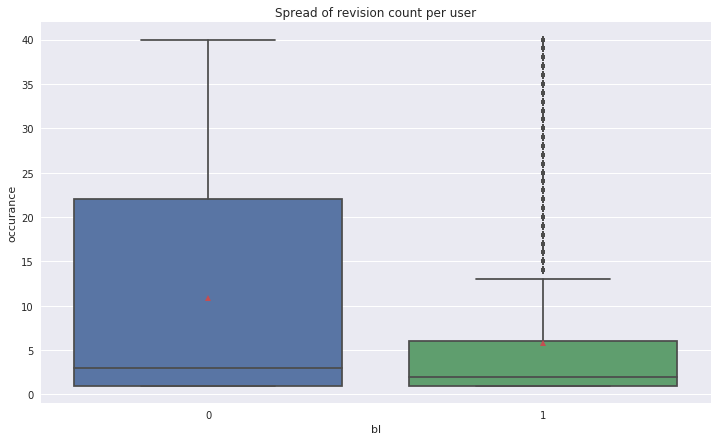

In [17]:
plt1 = pd.DataFrame(dbm.groupby(['username','bl'])['occurance'].agg(lambda x: max(x)))
plt1.reset_index(inplace=True)
print(plt1.groupby('bl')['occurance'].agg({'mean':np.average,'max':max}))
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
h1 = sns.boxplot(x='bl',y='occurance',data=plt1,showmeans=True).set_title('Spread of revision count per user')

In [18]:
dbm_cnt = dbm.groupby(['username','bl'])['occurance'].agg({'size1':np.size})
dbm_cnt.reset_index(inplace=True)
print(np.percentile(dbm_cnt[dbm_cnt['bl']==1].size1,[80, 25]))
np.percentile(dbm_cnt[dbm_cnt['bl']==0].size1,[80, 25])
#iqr = np.subtract(*np.percentile(x, [75, 25]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[8. 1.]


array([24.,  1.])

#### Spread of Active Days - Non Blocked users

(array([2635., 2200., 2323., 2261., 1998., 1805., 1772., 1704., 1574.,
        1615., 1545., 1656., 1621., 1362., 1343., 1444., 1412., 1504.,
        1801., 1642., 1588., 1492., 1444., 1602., 1501., 1538., 1515.,
        1409., 3046.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

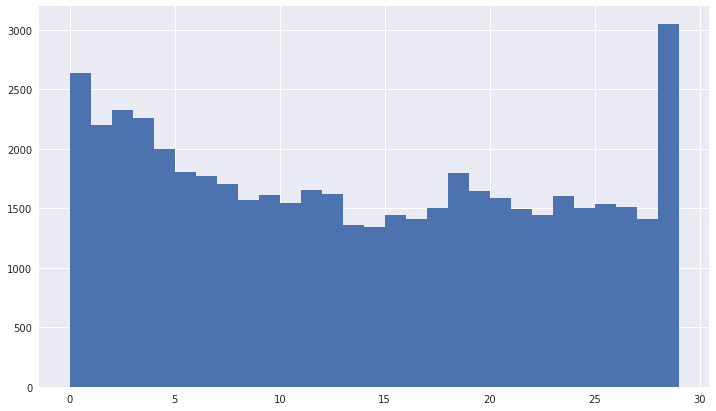

In [19]:
dbm['doi'] = (dbm.bl_date - dbm.revision_date)/7
dbm_b = dbm[dbm['bl']==0]
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
plt.hist(dbm_b.doi.dt.days,bins=np.arange(0,30,1))

#### Spread of Active Days - Blocked users

(array([43253.,  5905.,  3359.,  2723.,  1759.,  1577.,  1366.,  1166.,
          960.,   793.,   670.,   744.,   705.,   546.,   595.,   516.,
          449.,   523.,   397.,   412.,   345.,   423.,   271.,   355.,
          265.,   237.,   250.,   331.,   553.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

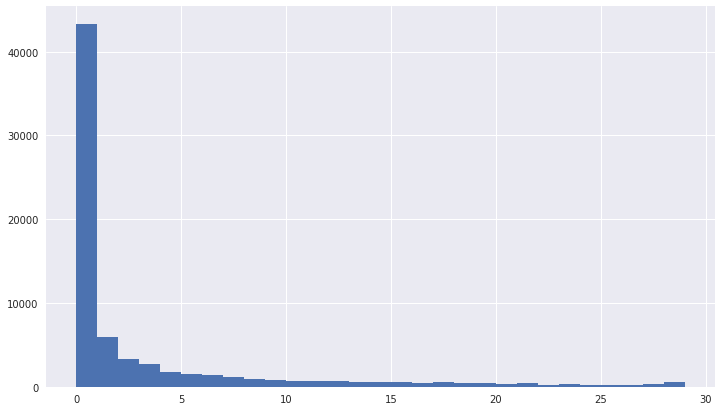

In [20]:
dbm_nb = dbm[dbm['bl']==1]
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
plt.hist(dbm_nb.doi.dt.days,bins=np.arange(0,30,1))

In [21]:
#Filtering data for top-10 comments or comments within one week each
dbm['valid_dt'] = 1
print(len(dbm))
dbm.loc[((dbm.bl==1)&(dbm.doi>'7 days')),'valid_dt']=0
dbm = dbm.loc[(dbm.valid_dt==1)]
print(len(dbm))
print("Count of Non-Blocked comment",len(dbm[dbm['bl']==0]),"\n Count of Blocked comment",len(dbm[dbm['bl']==1]))

302680
266863
Count of Non-Blocked comment 206732 
 Count of Blocked comment 60131


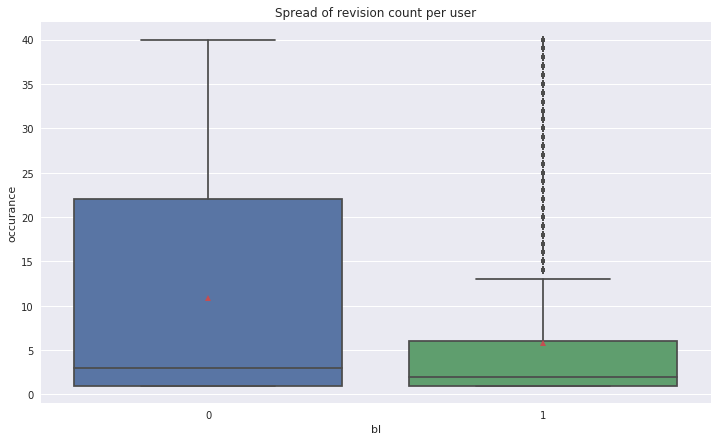

In [22]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
h1 = sns.boxplot(x='bl',y='occurance',data=plt1,showmeans=True).set_title('Spread of revision count per user')

In [23]:
dbm = dbm.loc[(dbm.occurance<=15)]
print(len(dbm))
print("Count of Non-Blocked comment",len(dbm[dbm['bl']==0]),"\n Count of Blocked comment",len(dbm[dbm['bl']==1]))
dbm.head()

176553
Count of Non-Blocked comment 125634 
 Count of Blocked comment 50919


,char_changes,revision_date,username,text,bl,rev_id,occurance
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5


In [26]:
dbm.text = dbm.text.astype('str')

In [27]:
dbm_all = dbm

In [28]:
dbm = dbm.groupby(['username','bl']).apply(lambda x: " ".join(x.text)).to_frame().rename(columns={0:'text'})
dbm.reset_index(inplace=True)
print(dbm.bl.value_counts())
dbm.head()

0    19993
1    11376
Name: bl, dtype: int64


,username,bl,text
0,! Bikkit !,0,::::In the meantime I learnt that - no matter ...
1,!MNc99,0,== Genre ==Can I suggest we change the genre o...
2,!Silent,0,:@{{U|92.231.176.195}} Thanks! [[User:!Silent|...
3,!dea4u,0,::{{u|Flibirigit}} no i do not feel that it i...
4,!kjjk1992jk!,0,1)\tIndustry Definition\t\tThe bakery industry...


In [29]:
#dbm.to_csv('dbm_b4.txt',sep="\t")

### Feature Engineering + Data Cleaning ( Test corpus)

In [30]:
dbm.text = dbm.text.str.strip()
dbm.text = dbm.text.str.replace('(\d{1,2}:\d{1,2}, \d{1,2} [A-Za-z]* \d{1,4} \(UTC)\)'," ")
dbm.text = dbm.text.str.replace('({{[\w|\W]*?}})'," ")
dbm.text = dbm.text.str.replace('(\[\[[\w|\W]*?\]\])'," ")
dbm.text = dbm.text.str.replace('(\{\|[\w|\W]*\|\})'," ")
dbm.text = dbm.text.str.replace('(<![\w|\W]*?>)'," ")
dbm.text = dbm.text.str.replace('(<[\w|\W]*?/>)'," ")

In [31]:
dbm['clen'] = dbm.text.str.len()
dbm['numb'] = dbm.text.str.count(r'\d')/dbm['clen']
dbm['caps'] = dbm.text.str.count(r'[A-Z]')/dbm['clen']
dbm['caps_ncaps'] = dbm.text.str.count(r'[A-Z]')/dbm_all.text.str.count(r'[a-z]')
dbm['wordlen'] = dbm.text.apply(lambda x: len(str(x).split()))
dbm['schar'] = (dbm.text.str.count(r'\W')-dbm.text.str.count(r'\W\S'))/dbm['clen']
dbm['unique_wlen_percent']=(dbm.text.apply(lambda x: len(set(str(x).split()))))/dbm['wordlen']
dbm['clen_wlen']=dbm['clen']/dbm['wordlen']
dbm.head()

,username,bl,text,clen,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen
0,! Bikkit !,0,::::In the meantime I learnt that - no matter ...,2593,0.033166,0.049364,0.514056,336,0.059391,0.675595,7.717262
1,!MNc99,0,== Genre ==Can I suggest we change the genre o...,2553,0.004700,0.030944,0.951807,435,0.062671,0.597701,5.868966
2,!Silent,0,:@ Thanks! ( ),19,0.000000,0.052632,0.002959,4,0.473684,1.000000,4.750000
3,!dea4u,0,:: no i do not feel that it is not construct...,1537,0.011711,0.031880,0.108168,249,0.080677,0.662651,6.172691
4,!kjjk1992jk!,0,1)\tIndustry Definition\t\tThe bakery industry...,8663,0.020778,0.026088,1.000000,1385,0.021471,0.443321,6.254874


In [32]:
dbm.text = dbm.text.str.replace('(={2,})'," ")
dbm.text = dbm.text.str.replace('(:{2,})'," ")
dbm.text = dbm.text.str.replace('(\s{2,})'," ")

In [33]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...


True

In [34]:
#Sentiment analyzer
sentiment_val = dbm.text.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

pol_values=[]
for i in sentiment_val:
    pol_val = list(i.values())
    pol_values.append(pol_val)

sent = pd.DataFrame(pol_values)
sent.rename(columns = {0:'neg',1:'neu',2:'pos',3:'compound'}, inplace=True)
sent.drop('pos', axis=1,inplace=True)
sent.head()

,neg,neu,compound
0,0.031,0.852,0.9745
1,0.035,0.860,0.9860
2,0.567,0.000,-0.2244
3,0.034,0.782,0.9906
4,0.027,0.832,0.9994


In [35]:
dbm = pd.merge(dbm,sent,how='inner',left_index=True,right_index=True)
dbm.shape
dbm[dbm.neg>0.6].head(10)

,username,bl,text,clen,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
30,(TIB1024H) (Volgren),1,DICK,4,0.0,1.000000,NaN,1,0.000000,1.000000,4.000000,1.000,0.000,-0.5106
35,(TPD ACB EMD),1,F*CK ME DADDY OSHWAHHHHHH Blocked Blocked Bloc...,70,0.0,0.342857,0.112150,13,0.214286,0.461538,5.384615,0.612,0.388,-0.6486
119,007Overlord,0,Stop trolling Stop trolling. Stop trolling,42,0.0,0.071429,NaN,6,0.023810,0.500000,7.000000,0.688,0.312,-0.6808
562,1.9.216.88,0,Fuck off@,9,0.0,0.111111,0.004630,2,0.111111,1.000000,4.500000,0.778,0.222,-0.5423
733,101.127.207.162,0,Blocked,16,0.0,0.062500,NaN,3,0.375000,0.666667,5.333333,1.000,0.000,-0.2732
735,101.127.209.17,0,It was a mistake Typo error,32,0.0,0.062500,NaN,7,0.062500,1.000000,4.571429,0.630,0.370,-0.6249
944,103.1.70.65,0,No? ( ),11,0.0,0.090909,0.003623,3,0.636364,1.000000,3.666667,1.000,0.000,-0.2960
971,103.14.62.240,0,Fuck you Fuck you,22,0.0,0.090909,NaN,5,0.090909,0.800000,4.400000,0.778,0.222,-0.7906
997,103.18.40.202,0,Pomak You are a terrorist,25,0.0,0.080000,0.111111,5,0.000000,1.000000,5.000000,0.610,0.390,-0.6908
1104,103.224.49.122,0,kill yourself,16,0.0,0.000000,NaN,2,0.125000,1.000000,8.000000,0.825,0.175,-0.6908


In [36]:
dbm_sent_chk = dbm

In [37]:
#Cleaning
print(len(dbm))
dbm.text = dbm.text.str.lower()
dbm.text = dbm.text.str.replace('[^a-zA-Z]'," ")
dbm.text = dbm.text.str.replace(r'\n',' ')
dbm.text = dbm.text.str.replace(r'\s+',' ')
dbm.text = dbm.text.str.replace('([ ]{2,})',' ')
dbm = dbm[~dbm.text.str.match(r'^\s*$')]
dbm = dbm[dbm.text.apply(lambda x:len(x))>10]
print(len(dbm))
dbm.head()

31369
29430


,username,bl,text,clen,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,! Bikkit !,0,in the meantime i learnt that no matter what ...,2593,0.033166,0.049364,0.514056,336,0.059391,0.675595,7.717262,0.031,0.852,0.9745
1,!MNc99,0,genre can i suggest we change the genre of th...,2553,0.004700,0.030944,0.951807,435,0.062671,0.597701,5.868966,0.035,0.860,0.9860
3,!dea4u,0,no i do not feel that it is not constructive ...,1537,0.011711,0.031880,0.108168,249,0.080677,0.662651,6.172691,0.034,0.782,0.9906
4,!kjjk1992jk!,0,industry definition the bakery industry can b...,8663,0.020778,0.026088,1.000000,1385,0.021471,0.443321,6.254874,0.027,0.832,0.9994
5,!rehtom,0,darren aronofsky larger budget productions th...,1507,0.000000,0.028534,0.252941,254,0.028534,0.649606,5.933071,0.068,0.821,0.8944


In [39]:
#dbm.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/dbm_after_new_corpus_all_22_02.txt',sep="\t")

In [40]:
#dbm[['username','bl']].to_csv('dbm_user_list_22_02.txt',sep="\t")

### Feature Engineering + Data Cleaning + Training

In [40]:
dbm_all.head()

,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,2019-01-01,159 days 00:00:00,1
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,1
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3,2019-01-01,159 days 03:25:42.857142,1
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,2019-01-01,171 days 10:17:08.571428,1
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,2019-01-01,172 days 03:25:42.857142,1


In [41]:
dbm_all.text = dbm_all.text.str.strip()
dbm_all.text = dbm_all.text.str.replace('(\d{1,2}:\d{1,2}, \d{1,2} [A-Za-z]* \d{1,4} \(UTC)\)'," ")
dbm_all.text = dbm_all.text.str.replace('({{[\w|\W]*?}})'," ")
dbm_all.text = dbm_all.text.str.replace('(\[\[[\w|\W]*?\]\])'," ")
dbm_all.text = dbm_all.text.str.replace('(\{\|[\w|\W]*\|\})'," ")
dbm_all.text = dbm_all.text.str.replace('(<![\w|\W]*?>)'," ")
dbm_all.text = dbm_all.text.str.replace('(<[\w|\W]*?/>)'," ")

In [42]:
dbm_all['clen'] = dbm_all.text.str.len()
dbm_all['numb'] = dbm_all.text.str.count(r'\d')/dbm['clen']
dbm_all['caps'] = dbm_all.text.str.count(r'[A-Z]')/dbm['clen']
dbm_all['caps_ncaps'] = dbm_all.text.str.count(r'[A-Z]')/dbm_all.text.str.count(r'[a-z]')
dbm_all['wordlen'] = dbm_all.text.apply(lambda x: len(str(x).split()))
dbm_all['schar'] = (dbm_all.text.str.count(r'\W')-dbm_all.text.str.count(r'\W\S'))/dbm_all['clen']
dbm_all['unique_wlen_percent']=(dbm_all.text.apply(lambda x: len(set(str(x).split()))))/dbm_all['wordlen']
dbm_all['clen_wlen']=dbm_all['clen']/dbm_all['wordlen']
dbm_all.head()

,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt,clen,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,2019-01-01,159 days 00:00:00,1,315,0.000000,0.004242,0.051643,62,0.066667,0.790323,5.080645
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,1,70,0.000000,0.000392,0.021277,12,0.128571,1.000000,5.833333
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,3,2019-01-01,159 days 03:25:42.857142,1,551,NaN,NaN,0.201987,35,0.039927,0.885714,15.742857
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,2019-01-01,171 days 10:17:08.571428,1,571,0.001952,0.014964,0.055288,78,0.059545,0.807692,7.320513
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,2019-01-01,172 days 03:25:42.857142,1,260,0.000693,0.000693,0.033149,35,0.069231,1.000000,7.428571


In [43]:
dbm_all.text = dbm_all.text.str.replace('(={2,})'," ")
dbm_all.text = dbm_all.text.str.replace('(:{2,})'," ")
dbm_all.text = dbm_all.text.str.replace('(\s{2,})'," ")

In [45]:
#Sentiment analyzer
sentiment_val = dbm_all.text.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

pol_values=[]
for i in sentiment_val:
    pol_val = list(i.values())
    pol_values.append(pol_val)

sent = pd.DataFrame(pol_values)
sent.rename(columns = {0:'neg',1:'neu',2:'pos',3:'compound'}, inplace=True)
sent.drop('pos', axis=1,inplace=True)
sent.head()

,neg,neu,compound
0,0.075,0.849,-0.2263
1,0.000,1.000,0.0000
2,0.000,0.916,0.3182
3,0.000,0.862,0.8604
4,0.000,0.870,0.4927


In [46]:
dbm_all = pd.merge(dbm_all,sent,how='inner',left_index=True,right_index=True)
dbm_all.shape
dbm_all[dbm_all.neg>0.6].head(10)

,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt,...,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
173,+130,2018-05-23,(127.0.0.1),":Hello, can I still edit my page? ( )",1,842660787,3,2018-05-23,0 days 00:00:00,1,...,0.000000,0.002574,0.090909,9,0.195122,1.000000,4.555556,1.000,0.000,-0.5106
898,+206,2017-05-06,-jkb-,Could somebody archive this?? ( ) Could somebo...,0,779087803,6,2019-01-01,86 days 10:17:08.571428,1,...,0.000000,0.000424,0.043478,12,0.175676,0.500000,6.166667,0.688,0.312,-0.2960
899,+222,2017-03-29,-jkb-,At this point I don't have the feeling we disc...,0,772728194,7,2019-01-01,91 days 20:34:17.142857,1,...,0.000000,0.005650,0.026786,31,0.051948,0.774194,4.967742,0.688,0.312,-0.2960
900,+187,2017-03-23,-jkb-,... not as anonymous as you could think - [ht...,0,771799296,8,2019-01-01,92 days 17:08:34.285714,1,...,0.105882,0.011765,0.015385,16,0.142857,0.937500,7.437500,0.688,0.312,-0.2960
2244,+153,2017-10-31,0xjamica0x,,0,808082281,1,2019-01-01,61 days 00:00:00,1,...,0.000000,0.000000,NaN,0,1.000000,NaN,inf,0.778,0.222,-0.5423
2248,+291,2018-01-26,0zero9nine,:Go to my Userpage or Talk page and look at th...,0,822497863,3,2019-01-01,48 days 13:42:51.428571,1,...,0.000000,0.166667,0.056738,41,0.054726,0.878049,4.902439,0.872,0.128,-0.7783
2406,+397,2017-08-27,1.122.169.213,W Motors No. Of employees Hi.I saw you undid ...,0,797495632,2,2019-01-01,70 days 06:51:25.714285,1,...,0.000851,0.002213,0.071038,47,0.055970,0.893617,5.702128,0.778,0.222,-0.5423
2815,+44,2018-03-17,1.152.104.94,You are engaging and causing the edit war.,0,830963134,5,2019-01-01,41 days 10:17:08.571428,1,...,0.000000,0.007042,0.030303,8,0.023810,1.000000,5.250000,0.681,0.319,-0.7506
2844,+739,2017-08-23,1.160.17.30,"Neutral point of view An editor has claimed ""...",0,796784284,2,2019-01-01,70 days 20:34:17.142857,1,...,0.000000,0.068493,0.025000,46,0.072993,0.913043,5.956522,0.624,0.376,-0.8074
3016,+110,2018-06-19,1.247.135.183,"One more, please educate yourself before using...",0,846573645,5,2019-01-01,28 days 00:00:00,1,...,0.000000,0.083333,0.057471,15,0.027523,1.000000,7.266667,1.000,0.000,-0.2732


In [47]:
#Cleaning
print(len(dbm))
dbm_all.text = dbm_all.text.str.lower()
dbm_all.text = dbm_all.text.str.replace('[^a-zA-Z]'," ")
dbm_all.text = dbm_all.text.str.replace(r'\n',' ')
dbm_all.text = dbm_all.text.str.replace(r'\s+',' ')
dbm_all.text = dbm_all.text.str.replace('([ ]{2,})',' ')
dbm_all = dbm_all[~dbm_all.text.str.match(r'^\s*$')]
dbm_all = dbm_all[dbm_all.text.apply(lambda x:len(x))>10]
print(len(dbm_all))
dbm_all.head()

29430
88988


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt,...,numb,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,159 days 00:00:00,1,...,0.000000,0.004242,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263
1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,1,...,0.000000,0.000392,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000
2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,159 days 03:25:42.857142,1,...,NaN,NaN,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182
3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,171 days 10:17:08.571428,1,...,0.001952,0.014964,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604
4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,172 days 03:25:42.857142,1,...,0.000693,0.000693,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927


### Modeling

In [72]:
dbm.shape

(29430, 14)

In [50]:
def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [51]:
X_train = dbm.drop(['bl'],axis=1)
y_train = dbm['bl']

X_test = dbm_all.drop(['bl'],axis=1)
y_test = dbm_all['bl']

In [73]:
X_train.columns

Index(['username', 'text', 'clen', 'numb', 'caps', 'caps_ncaps', 'wordlen',
       'schar', 'unique_wlen_percent', 'clen_wlen', 'neg', 'neu', 'compound'],
      dtype='object')

#### Word n-gram model

In [53]:
vect = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(1,2),max_features=1500).fit(X_train['text'])
X_train_word = vect.transform(X_train['text'])
X_test_word = vect.transform(X_test['text'])

#### Character n-gram model

In [74]:
vect_c = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(2,6),analyzer='char',max_features=5000).fit(X_train['text'])
X_train_char = vect_c.transform(X_train['text'])
X_test_char = vect_c.transform(X_test['text'])

In [75]:
print(X_train_word.shape)
print(X_test_word.shape)

X_train_comb = hstack([X_train_word,X_train_char])
X_test_comb = hstack([X_test_word,X_test_char])

print(X_train_comb.shape)

(29430, 1500)
(88988, 1500)
(29430, 6500)


#### Char + word n-gram + sentiment

In [77]:
print(X_train_comb.shape)
for i in X_train.columns:
    if i not in ['text','username']:
        X_train_comb = add_feature(X_train_comb,X_train[i])
print(X_train_comb.shape)

(29430, 6500)
(29430, 6511)


In [78]:
print(X_test_comb.shape)
for i in X_test.columns:
    if i not in ['text','username','revision_date','char_changes','occurance','bl_date','doi','valid_dt','rev_id']:
        X_test_comb = add_feature(X_test_comb,X_test[i])
print(X_test_comb.shape)        

(88988, 6500)
(88988, 6511)


#### Latent Dirichlet Allocation

In [60]:
lda = LatentDirichletAllocation(n_components=20, max_iter=20,learning_method='online', random_state=0)
#Online faster
lda.fit(X_train_word)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [61]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [62]:
tf_feature_names = vect.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words=10)

Topic #0: thank hello man dont ad king tv title improvement car
Topic #1: ref love ref ref super create review david age submission ac
Topic #2: hey welcome just new fun add nice happy won okay
Topic #3: unblock nd care mr head provide rights needed agree truth
Topic #4: philippines late respect worth case university years white country posted
Topic #5: sock table hope talking takes obviously focus concern definitely moved
Topic #6: text stupid bold wikipedia fake thing mother tom ban weight
Topic #7: did stop edits thanks like warning vandalism wikipedia nowiki wikipedia did
Topic #8: hi com https org www redirect wikipedia org wiki http promotional
Topic #9: help im good article college lost trust improvement email longer
Topic #10: span style em font span style px color align family style background
Topic #11: article page wikipedia just like thanks edit don know thank
Topic #12: block blocked account div br talk user editing username unblocked
Topic #13: nbsp nbsp div style diff pr

In [64]:
tr_topics = lda.transform(X_train_word)
tt_topics = lda.transform(X_test_word)
tr1 = pd.DataFrame(tr_topics)
y_train1n = pd.DataFrame(y_train)
y_train1n.reset_index(inplace=True)
y_train1n.drop(columns = ['index'],inplace=True)
y_train1n.head()

,bl
0,0
1,0
2,0
3,0
4,0


In [65]:
xt = pd.DataFrame(X_train_comb.todense())
print(xt.shape)
print(y_train1n.shape)
xt_c = pd.concat([xt,y_train1n],axis=1)
print(xt_c.shape)

(29430, 8511)
(29430, 1)
(29430, 8512)


In [79]:
print(X_train_comb.shape)

X_train_comb2 = hstack([X_train_comb,tr_topics])
X_test_comb2 = hstack([X_test_comb,tt_topics])

print(X_train_comb2.shape)
X_test_comb2.shape

(29430, 6511)
(29430, 6531)


(88988, 6531)

In [80]:
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_detection_03_14.npz', X_test_comb2)
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train__detection_03_14.npz', X_train_comb2)

X_test_comb2 = scipy.sparse.load_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_detection_03_02.npz')
print(X_test_comb2.shape)
X_train_comb2 = scipy.sparse.load_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train__detection_03_02.npz')
print(X_train_comb2.shape)

#### Using XGBoost Classifier

In [81]:
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5)
xgb.fit(X_train_comb2, y_train)

[22:43:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:43:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:43:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:43:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:43:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:44:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:44:04] /opt/conda/conda-bld/xgboost_

[22:47:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:47:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:47:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:47:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:47:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:47:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:47:46] /opt/conda/conda-bld/xgboost_

[22:51:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:51:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:51:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:51:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:51:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:51:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:51:24] /opt/conda/conda-bld/xgboost_

[22:54:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:54:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:54:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[22:54:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:54:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:54:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:54:59] /opt/conda/conda-bld/xgboost_

[22:58:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[22:58:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:58:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:58:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:58:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[22:58:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:58:32] /opt/conda/conda-bld/xgboost_

[23:01:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:01:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:01:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:01:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:01:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:02:05] /opt/conda/conda-bld/xgboost_

[23:05:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:05:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:05:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:05:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:05:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:05:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:05:36] /opt/conda/conda-bld/xgboost_

[23:08:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:08:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:08:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:08:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:09:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:09:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:09:09] /opt/conda/conda-bld/xgboost_

[23:12:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:12:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:12:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:12:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:12:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:12:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:12:50] /opt/conda/conda-bld/xgboost_

[23:15:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:16:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:16:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:16:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:16:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:16:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:16:22] /opt/conda/conda-bld/xgboost_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=0, subsample=1)

In [82]:
predictions_xgb = xgb.predict(X_test_comb2)
auc = roc_auc_score(y_test, predictions_xgb)
auc

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6678207716238772

In [79]:
predictions2_xgb = pd.DataFrame(predictions_xgb)
predictions2_xgb.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/predictions_xgb_detection_03_02.txt',sep="\t")

In [83]:
predictions_xgb_probab = xgb.predict_proba(X_test_comb2)
predictions_xgb_probab = pd.DataFrame(predictions_xgb_probab)

In [84]:
predictions_xgb_probab.rename(columns={1:'abuse_score'},inplace=True)

In [85]:
predictions_xgb_probab = predictions_xgb_probab[['abuse_score']]
predictions_xgb_probab.head()

,abuse_score
0,0.186580
1,0.401340
2,0.150583
3,0.086982
4,0.129014


In [88]:
dbm_all_r =dbm_all.reset_index()
dbm_all_pred = pd.concat([dbm_all_r,predictions_xgb_probab],axis=1)
print(dbm_all_pred.shape)
dbm_all_pred.head()

(88988, 23)


,index,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,...,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound,abuse_score
0,0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,159 days 00:00:00,...,0.004242,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263,0.186580
1,1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,159 days 03:25:42.857142,...,0.000392,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000,0.401340
2,2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,159 days 03:25:42.857142,...,NaN,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182,0.150583
3,3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,171 days 10:17:08.571428,...,0.014964,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604,0.086982
4,4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,172 days 03:25:42.857142,...,0.000693,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927,0.129014


#### Trend of Abuse scores for Blocked and Non-Blocked Users

In [89]:
dbm_all_pred.groupby(['bl','occurance']).agg({'abuse_score':np.mean})

abuse_score
bl occurance             
0  1             0.258926
   2             0.295965
   3             0.302574
   4             0.309167
   5             0.311490
   6             0.314564
   7             0.313943
   8             0.305024
   9             0.308323
   10            0.314635
   11            0.305735
   12            0.309592
   13            0.312786
   14            0.310813
   15            0.310718
1  1             0.588665
   2             0.517820
   3             0.484387
   4             0.468687
   5             0.454223
   6             0.448079
   7             0.444466
   8             0.437308
   9             0.434393
   10            0.423982
   11            0.417059
   12            0.411756
   13            0.410708
   14            0.410040
   15            0.400276

In [94]:
dbm_all_pred.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/detection_user_level_pred_03_02.txt',sep="\t", header=True)

In [95]:
newd = pd.read_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/detection_user_level_pred_03_02.txt',sep="\t")
newd.head()

,Unnamed: 0,index,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,...,caps,caps_ncaps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound,abuse_score
0,0,0,+407,2015-12-15,! Bikkit !,in the meantime i learnt that no matter what ...,0,695331950,1,2019-01-01,...,0.004242,0.051643,62,0.066667,0.790323,5.080645,0.075,0.849,-0.2263,0.186580
1,1,1,+156,2015-12-14,! Bikkit !,i haved shifted this discussion to the articl...,0,695241872,2,2019-01-01,...,0.000392,0.021277,12,0.128571,1.000000,5.833333,0.000,1.000,0.0000,0.401340
2,2,2,+642,2015-12-14,! Bikkit !,lemma i followed the title exactly the i ist ...,0,695177648,3,2019-01-01,...,NaN,0.201987,35,0.039927,0.885714,15.742857,0.000,0.916,0.3182,0.150583
3,3,3,+663,2015-09-19,! Bikkit !,forwarded thank you in the https de wikipedia...,0,681751098,4,2019-01-01,...,0.014964,0.055288,78,0.059545,0.807692,7.320513,0.000,0.862,0.8604,0.086982
4,4,4,+370,2015-09-14,! Bikkit !,mathematical tourist http mathtourist blogspo...,0,680954373,5,2019-01-01,...,0.000693,0.033149,35,0.069231,1.000000,7.428571,0.000,0.870,0.4927,0.129014


In [88]:
dbm_all_pred.rev_id.nunique()

58064

In [106]:
dbm_all_pred.shape

(58064, 23)